In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd

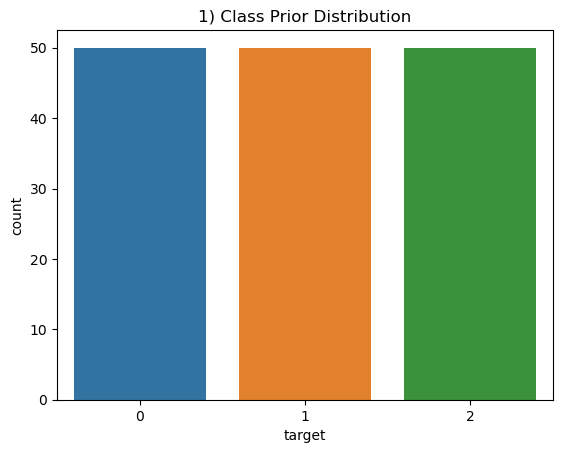

In [2]:
# 1) Class Prior Distribution

"""
- Plot name: Class Prior Distribution
- Purpose: Visualize the balance of classes in the dataset.
- Why use it: Naive Bayes relies on prior probabilities (P(Class)).
- When to use: Before training, during exploratory analysis.
- X-axis: Class labels
- Y-axis: Number of samples
- Intuition: Imbalanced priors bias predictions toward larger classes.
"""
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

sns.countplot(x='target', data=df)
plt.title("1) Class Prior Distribution")
plt.show()

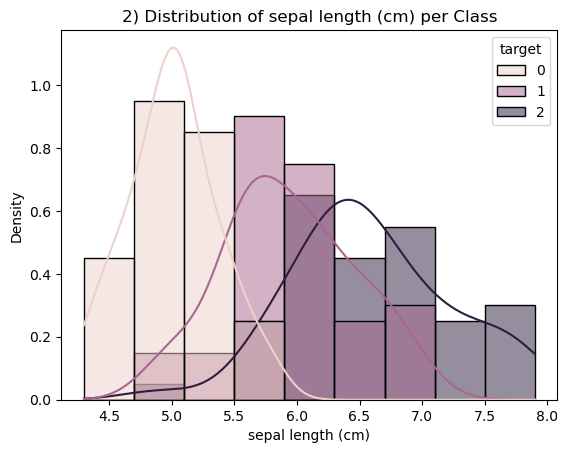

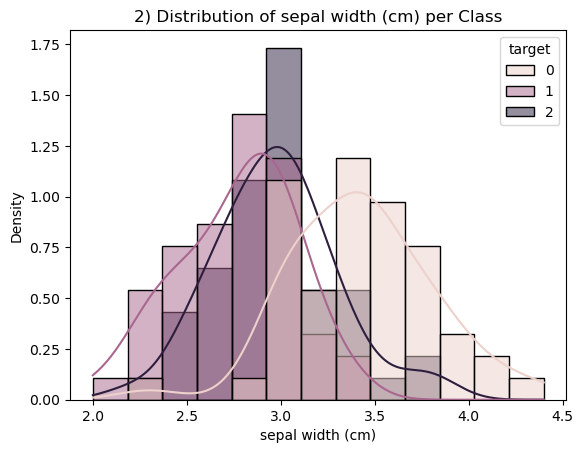

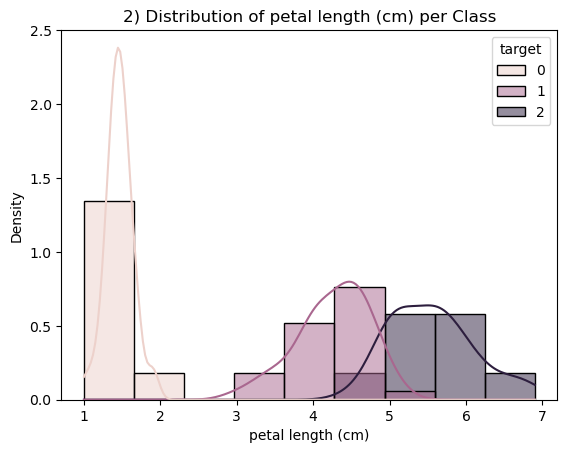

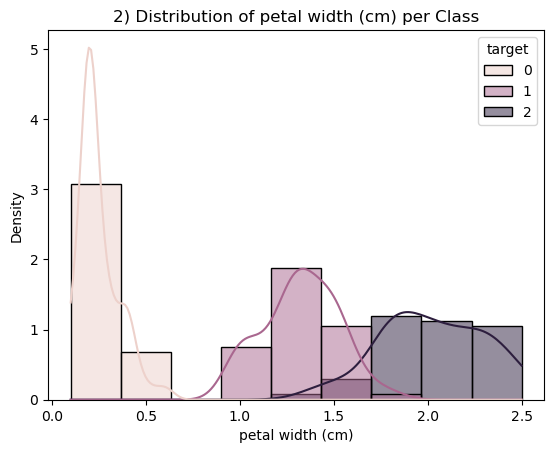

In [3]:
# 2) Feature Distribution per Class

"""
- Plot name: Feature Distribution per Class
- Purpose: Compare each feature’s distribution across classes.
- Why use it: Naive Bayes assumes conditional independence;
  understanding overlap or separation helps test that assumption.
- When to use: Early exploratory phase.
- X-axis: Feature values
- Y-axis: Density
- Intuition: Distinct class-specific curves → useful features.
  Overlap → lower discriminative power.
"""
for feature in iris.feature_names:
    sns.histplot(data=df, x=feature, hue='target', kde=True, stat="density", common_norm=False)
    plt.title(f"2) Distribution of {feature} per Class")
    plt.show()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


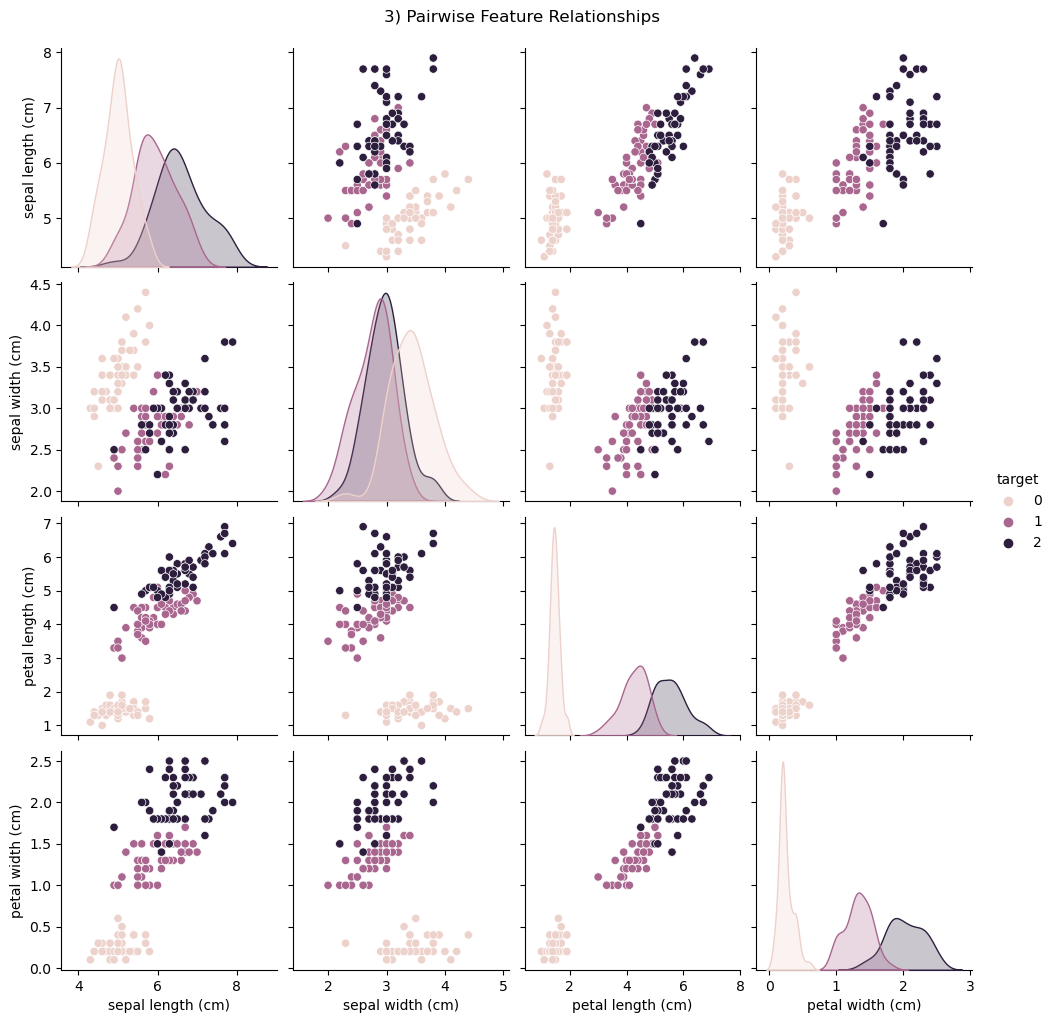

In [4]:
# 3) Pairwise Feature Relationships

"""
- Plot name: Pairplot of Features
- Purpose: Show pairwise feature relationships and class separation.
- Why use it: Visual check of the “independence” assumption.
- When to use: Exploratory Data Analysis (EDA).
- Axes: Feature pairs
- Intuition: Highly correlated features violate the independence
  assumption; well-separated clusters indicate strong discriminability.
"""
sns.pairplot(df, hue='target', vars=iris.feature_names)
plt.suptitle("3) Pairwise Feature Relationships", y=1.02)
plt.show()

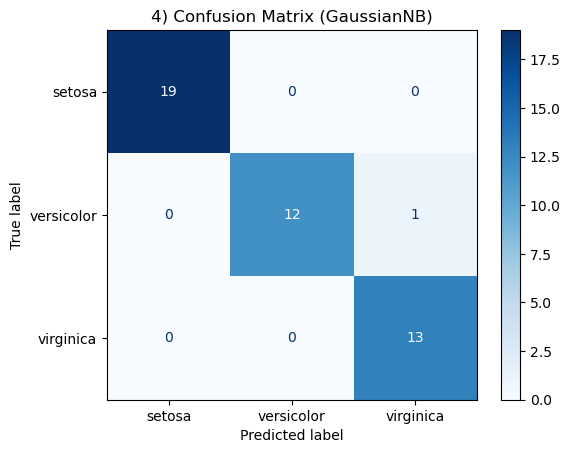

In [5]:

# 4) Confusion Matrix

"""
- Plot name: Confusion Matrix
- Purpose: Compare predicted vs true class labels.
- Why use it: To evaluate performance and detect misclassifications.
- When to use: After model prediction.
- X-axis: Predicted class
- Y-axis: Actual class
- Intuition: Strong diagonal = good performance; off-diagonals highlight specific confusion points.
"""
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(df[iris.feature_names], df['target'], test_size=0.3, random_state=42)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("4) Confusion Matrix (GaussianNB)")
plt.show()

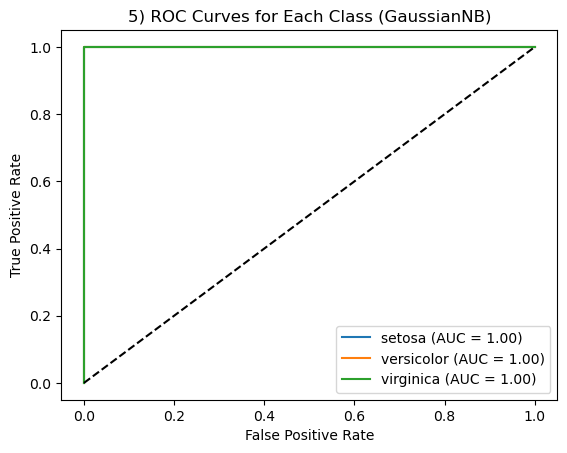

In [6]:
# 5) ROC Curves (Multiclass)

"""
- Plot name: ROC Curves (Multiclass)
- Purpose: Evaluate class-wise discrimination performance.
- Why use it: Naive Bayes outputs probabilities; ROC curves visualize how thresholds affect TPR/FPR.
- When to use: After obtaining model probabilities.
- X-axis: False Positive Rate
- Y-axis: True Positive Rate
- Intuition: Higher AUC means stronger class separability.
"""
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

y_test_bin = label_binarize(y_test, classes=[0,1,2])
y_score = model.predict_proba(X_test)

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    plt.plot(fpr, tpr, label=f"{iris.target_names[i]} (AUC = {auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5) ROC Curves for Each Class (GaussianNB)")
plt.legend()
plt.show()

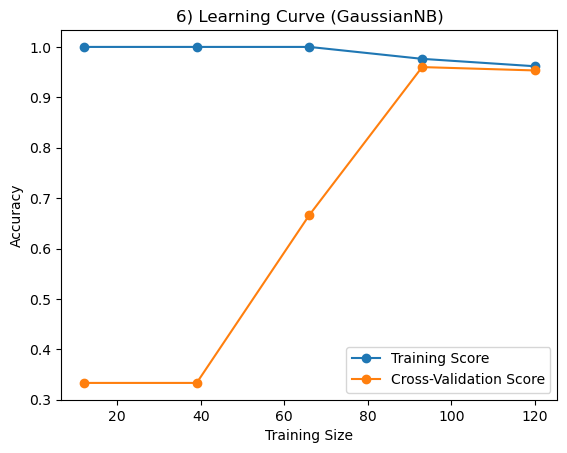

In [7]:
# 6) Learning Curve

"""
- Plot name: Learning Curve
- Purpose: Track how accuracy evolves with more training data.
- Why use it: Identify underfitting, overfitting, or sufficient data.
- When to use: Before deployment or retraining.
- X-axis: Number of training samples
- Y-axis: Accuracy
- Intuition: Plateau → model has learned all it can; divergence → bias or variance issues.
"""
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(GaussianNB(), df[iris.feature_names], df['target'], cv=5, train_sizes=np.linspace(0.1,1.0,5))

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("6) Learning Curve (GaussianNB)")
plt.legend()
plt.show()


In [8]:
# 7) Comparison Across Naive Bayes Types

"""
- Plot name: Model Comparison Dashboard
- Purpose: Compare GaussianNB, MultinomialNB, and BernoulliNB side-by-side.
- Why use it: Each variant assumes a different data distribution.
- When to use: Model selection and performance benchmarking.
- Metrics: Accuracy, F1, Log Loss, Confusion Matrix.
- Intuition:
    - GaussianNB → continuous data (normal distribution)
    - MultinomialNB → count data (text, frequencies)
    - BernoulliNB → binary or thresholded features
"""
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report

scaler = MinMaxScaler()
X_train_m = scaler.fit_transform(X_train) * 10
X_test_m = scaler.transform(X_test) * 10

binarizer = Binarizer(threshold=np.mean(X_train))
X_train_b = binarizer.fit_transform(X_train)
X_test_b = binarizer.transform(X_test)

models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}

results = {}
for name, model in models.items():
    if name == "MultinomialNB":
        X_tr, X_te = X_train_m, X_test_m
    elif name == "BernoulliNB":
        X_tr, X_te = X_train_b, X_test_b
    else:
        X_tr, X_te = X_train, X_test
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, average='weighted'),
        "logloss": log_loss(y_test, y_proba)
    }

# KPI Summary
kpi_df = pd.DataFrame(results).T
print("===== Naive Bayes Model Comparison =====")
print(kpi_df.round(3))

===== Naive Bayes Model Comparison =====
               accuracy     f1  logloss
GaussianNB        0.978  0.978    0.049
MultinomialNB     0.911  0.911    0.384
BernoulliNB       0.711  0.615    0.447


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
